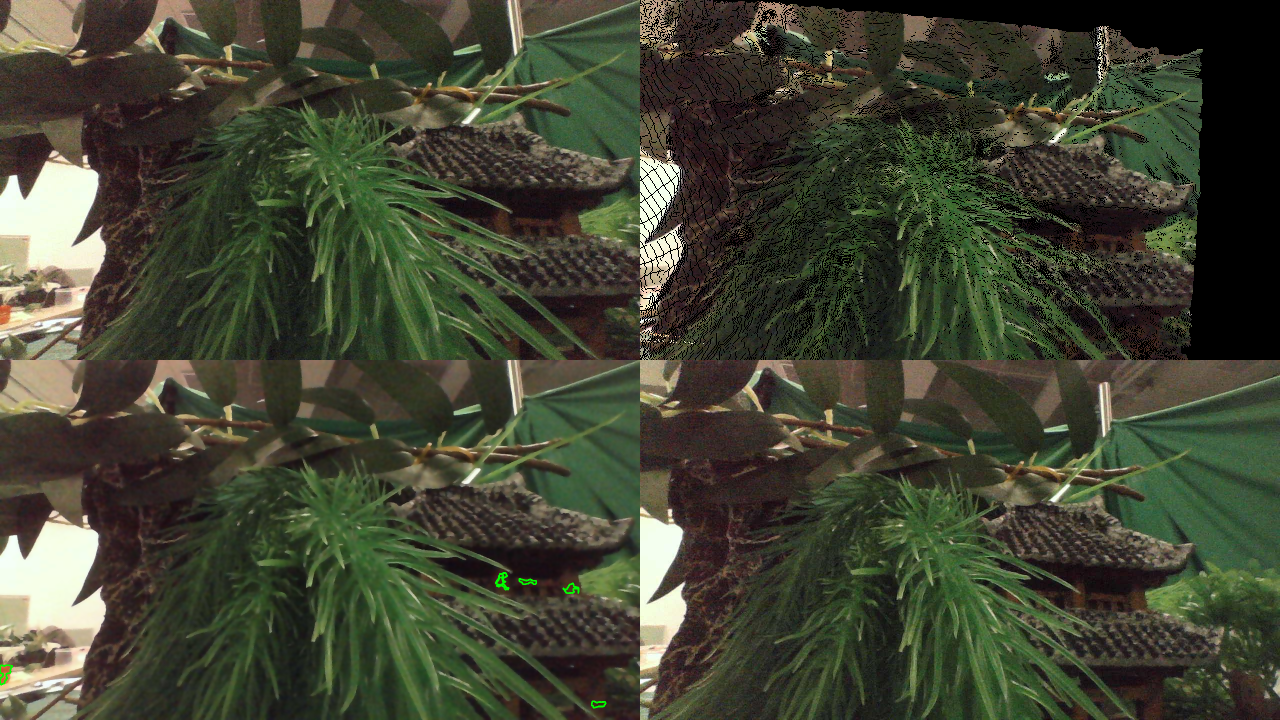

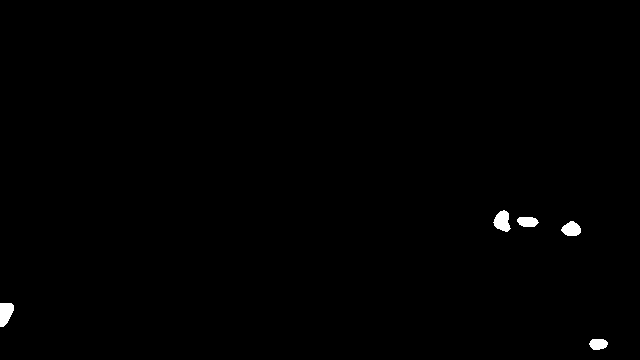

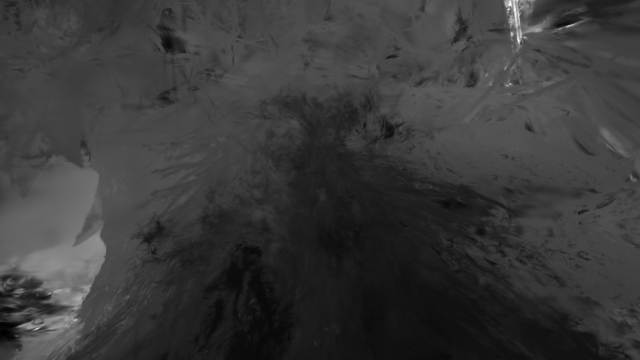

KeyboardInterrupt: 

In [24]:
import os
import cv2
import numpy as np
from scipy.spatial.transform import Rotation as R
import sys
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import time
import pdb
import lpips
from PIL import Image
from collections import Counter
import json
from tqdm import tqdm

import open3d as o3d

def detect_red(image_path):
    # Load the image
    image = cv2.imread(image_path)

    image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for red color in HSV
    lower_red = np.array([0, 130, 56])
    upper_red = np.array([10, 255, 255])

    # Create a mask for red regions
    red_mask = cv2.inRange(hsv_image, lower_red, upper_red)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel)

    # Find contours in the mask
    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_sum = 0

    contours_filter = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:
            contour_sum+=area 
            contours_filter.append(contour)
        #print(f"Contour Area: {area}")

    # Draw contours on the original image
    result_image = image.copy()
    cv2.drawContours(result_image, contours_filter, -1, (0, 255, 0), 2)
    red_mask_filter = np.zeros_like(red_mask)
    cv2.drawContours(red_mask_filter, contours_filter, -1, 1, thickness=cv2.FILLED)
    kernel = np.ones((5, 5), np.uint8)

    # 执行膨胀操作
    red_mask_filter = cv2.dilate(red_mask_filter, kernel, iterations=2)

    # 指定高斯核的大小（必须是奇数）
    kernel_size = (15, 15)

    # 指定高斯核的标准差
    sigma = 11.0

    # 应用高斯滤波
    red_mask_filter = cv2.GaussianBlur(red_mask_filter, kernel_size, sigma)
    return red_mask_filter, contour_sum, result_image

def split_list(input_list, chunk_size = 18):
    return [input_list[i:i+chunk_size] for i in range(0, len(input_list), chunk_size)]


def get_rt(txt_dir,target_name):
    img_txt = os.path.join(txt_dir,'images.txt')
    cam_txt = os.path.join(txt_dir, 'cameras.txt')
    with open(img_txt,'r') as f:
        ll = f.readlines()
    ll = ll[4:]

    ll = ll[::2]
    target_name = os.path.basename(target_name)
    target_name = target_name.replace('images_','')
    target_name = target_name[:-4]
    # target_name = target_name.split('.')[-2]
    for l in ll:
        cont = l.split()
        cam_name = os.path.basename(cont[9])
        cam_name = cam_name[:-4]
        if target_name == cam_name:
            #print(cam_name)
            rt = cont
            cam_ind = int(cont[8])
            break
    
    cam_name = os.path.basename(rt[9]).split('.')[0]

    #QW, QX, QY, QZ = [float(rt[1]), float(rt[2]),  float(rt[3]),  float(rt[4])]
    Rq1 = np.asarray([float(rt[2]),  float(rt[3]),  float(rt[4]), float(rt[1])])
    r1 = R.from_quat(Rq1)
    Rm1 = r1.as_matrix()
    T = np.asarray([float(rt[5]), float(rt[6]), float(rt[7])])

    with open(cam_txt,'r') as f:
        ll = f.readlines()
        ll = ll[3:]
    K = ll[cam_ind - 1]
    K = K.split()[4:]
    K = [float(i) for i in K]
    return Rm1, T, K

def relative_pose(R_view1, T_view1, R_view2, T_view2):

    # 计算相对位置变换
    R_relative = np.dot(R_view2, np.linalg.inv(R_view1))
    #T_relative = T_view2 - np.dot(R_view2, T_view1)
    T_relative = T_view2 - np.dot(R_view2, T_view1)
    # 构造相对位置变换矩阵
    relative_transform = np.identity(4)
    relative_transform[:3, :3] = R_relative
    relative_transform[:3, 3] = T_relative
    return relative_transform

def project_depth_rgb(K1,K2,relative_transform,depth_image_A,rgb_A = None):
    # 视角B相对于视角A的姿态变换矩阵
    pose_A_to_B = np.array(relative_transform)  # 4x4姿态矩阵

    fx,fy,cx,cy = K1

    camera_matrix_A = np.array([[fx, 0, cx],
                                [0, fy, cy],
                                [0, 0, 1]])
    # 视角B相对于视角A的姿态变换矩阵
    pose_A_to_B = np.array(relative_transform)  # 4x4姿态矩阵
    # 视角B相机内参
    fx2,fy2,cx2,cy2 = K2
    camera_matrix_B = np.array([[fx2, 0, cx2],
                                [0, fy2, cy2],
                                [0, 0, 1]])

    # 获取视角A图像的高度和宽度
    height_A, width_A = depth_image_A.shape[:2]

    # 创建视角B的空白RGB和深度图像
    if rgb_A is not None:
        rgb_image_B = np.zeros((height_A, width_A, 3), dtype=np.uint8)
    depth_image_B = np.zeros((height_A, width_A), dtype=np.float32)

    # 遍历视角A的每个像素
    for y in range(height_A):
        for x in range(width_A):
            # 获取视角A中的深度信息
            depth_A = depth_image_A[y, x]
            #print(depth_A)
            if depth_A > 0:
                # 计算视角A中像素的3D坐标
                #depth_A *= 0.1
                point_A = np.array([(x - cx) * depth_A / fx,
                                    (y - cy) * depth_A / fy,
                                    depth_A,1])

                point_B = np.dot(pose_A_to_B, point_A)
                # 将3D点从视角B坐标系投影回视角B图像平面
                u_B = int(point_B[0] * fx2 / point_B[2] + cx2)
                v_B = int(point_B[1] * fy2 / point_B[2] + cy2)

                if 0 <= u_B < width_A and 0 <= v_B < height_A:
                    depth_image_B[v_B, u_B] = depth_A
                    if rgb_A is not None:
                        rgb_image_B[v_B, u_B,:] = rgb_A[y, x,:]
    return depth_image_B, rgb_image_B

def project_depth_rgb2(K1, K2,R1, T1, R2, T2, rgb_A, depth_image_A):
    # open3d version
    depth_scale = 3000.0
    depth_max = 40.0
    fx1, fy1, cx1, cy1 = K1
    intrinsic_A = o3d.core.Tensor([[fx1, 0, cx1], [0, fy1, cy1], [0, 0, 1]])
    height_A, width_A = depth_image_A.shape[:2]
    depth_image_A10000 = depth_image_A * depth_scale
    depth_image_A10000 = depth_image_A10000.reshape(height_A, width_A).astype(np.uint16)
    device = o3d.core.Device('CPU:0')
    depth_image = o3d.t.geometry.Image(depth_image_A10000).to(device)
    color_image = o3d.t.geometry.Image(rgb_A).to(device)
    rgbd_image = o3d.t.geometry.RGBDImage(color_image, depth_image)
    extrinsic_A = np.eye(4)
    extrinsic_A[0:3, 0:3] = R1
    extrinsic_A[0:3, 3] = T1
    extrinsic_A = o3d.core.Tensor(extrinsic_A)
    pcd = o3d.t.geometry.PointCloud.create_from_rgbd_image(rgbd_image,
                                                            intrinsic_A, extrinsic_A, depth_scale=depth_scale, depth_max=depth_max)
    
    # project to camera2
    fx2, fy2, cx2, cy2 = K2
    intrinsic_B = o3d.core.Tensor([[fx2, 0, cx2], [0, fy2, cy2], [0, 0, 1]])
    extrinsic_B = np.eye(4)
    extrinsic_B[0:3, 0:3] = R2
    extrinsic_B[0:3, 3] = T2
    extrinsic_B = o3d.core.Tensor(extrinsic_B)
    rgbd_reproj = pcd.project_to_rgbd_image(width_A,
                                            height_A,
                                            intrinsic_B,
                                            extrinsic_B,
                                            depth_scale=depth_scale,
                                            depth_max=depth_max)
    rgb_reproj = np.asarray(rgbd_reproj.color.to_legacy())
    depth_reproj = np.asarray(rgbd_reproj.depth.to_legacy())
    return depth_reproj, rgb_reproj

def project_pipeline(txt_dir, img, img2, dep, dep2, red_mask = None):
    R1, T1, K1 = get_rt(txt_dir, img)
    R2, T2, K2 = get_rt(txt_dir, img2)

    relative_transform = relative_pose(R1, T1, R2, T2)

    depth_image_A = np.load(dep)
    rgb_A = cv2.imread(img)
    K1 = [k / 2 for k in K1]
    K2 = [k / 2 for k in K2]
    height, width = rgb_A.shape[:2]
    rgb_A = cv2.resize(rgb_A, (width // 2, height // 2))
    red_mask = cv2.resize(red_mask, (width // 2, height // 2))
    depth_image_A = cv2.resize(depth_image_A, (width // 2, height // 2))
    
    #T1 = time.perf_counter()
    #depth_image_B,rgb_B = project_depth_rgb(K1, K2,relative_transform, depth_image_A, rgb_A)
    depth_image_B, rgb_B = project_depth_rgb2(K1, K2,R1, T1, R2, T2, rgb_A, depth_image_A)
    #T2 = time.perf_counter()
    
    rgb_B_gt = cv2.imread(img2)
    rgb_B_gt = cv2.resize(rgb_B_gt,(width // 2, height // 2))

    mask = np.ones_like(depth_image_B)
    mask_zeros = (np.size(mask) - np.count_nonzero(mask)) / np.size(mask)
    mask[depth_image_B == 0] = 0
    mask_3 = np.stack((mask,mask,mask),2)

    img0 = lpips.im2tensor(rgb_B_gt*mask_3) # RGB image from [-1,1]
    img1 = lpips.im2tensor(rgb_B)
    # Compute distance lpips
    dist = loss_fn.forward(img0, img1).squeeze().item()
    
    rgb_B_ = rgb_B.astype(np.float32)
    rgb_B_gt_ = rgb_B_gt.astype(np.float32)
    costs = {'lpips_all':float(dist),'curiosity_all':float(mask_zeros)}
    if red_mask is not None:
        contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours = []
    if contours:
        dist_red = 0
        contour_sum = 0
        # 遍历每个轮廓并计算包围框的长和宽
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 100:
                contour_sum += area 
                x, y, w, h = cv2.boundingRect(contour)
                #red_mask_3 = np.stack((red_mask,red_mask,red_mask),2)
                rgb_B_gt_current = rgb_B_gt[y:y+h, x:x+w, :]
                rgb_B_current = rgb_B[y:y+h, x:x+w, :]
                rgb_B_gt_current = cv2.resize(rgb_B_gt_current,(100,100))
                rgb_B_current = cv2.resize(rgb_B_current,(100,100))
                img0 = lpips.im2tensor(rgb_B_gt_current) # RGB image from [-1,1]
                
                img1 = lpips.im2tensor(rgb_B_current)
                # Compute distance lpips
                dist_red += loss_fn.forward(img0, img1).squeeze().item()
        dist_red /= len(contours) 
        rgb_B_ = rgb_B.astype(np.float32)
        rgb_B_gt_ = rgb_B_gt.astype(np.float32)
        red_mask_3 = np.stack((red_mask,red_mask,red_mask),2)
        mask_zeros = np.count_nonzero((1 - mask) * red_mask) / np.size(mask)
    else:
        dist_red = 0
        mask_zeros = 0
        contour_sum = 0
    contour_avg = contour_sum / np.size(mask)
    costs['lpips_red'] = float(dist_red)
    costs['curiosity_all'] = float(mask_zeros)
    costs['red_avg_area'] = float(contour_avg)
    return rgb_A, depth_image_A, rgb_B, depth_image_B, rgb_B_gt, costs

def dict_counter(x,y):
    return dict(Counter(x)+Counter(y))


if __name__ == '__main__':
    temp_dir = '/data/jianing/dlf_depth_test'
    os.makedirs(temp_dir, exist_ok=True)
    root = '/data/jianing/output_829/colmap_1_1'

    train_depth_dir = os.path.join(root,'train','ours_10000','depth')
    test_depth_dir = os.path.join(root,'test','ours_10000','depth')

    train_img_dir = os.path.join(root,'train','ours_10000','gt')
    test_img_dir = os.path.join(root,'test','ours_10000','gt')

    ll_img_ref = [os.path.join(train_img_dir,i) for i in os.listdir(train_img_dir)]
    ll_img_test = [os.path.join(test_img_dir,i) for i in os.listdir(test_img_dir)]
    ll_dep_ref = [os.path.join(train_depth_dir,i) for i in os.listdir(train_depth_dir) if '.npy' in i]
    ll_dep_test = [os.path.join(test_depth_dir,i) for i in os.listdir(test_depth_dir) if '.npy' in i]

    ll_img_ref = sorted(ll_img_ref)
    ll_img_test = sorted(ll_img_test)
    ll_dep_ref = sorted(ll_dep_ref)
    ll_dep_test = sorted(ll_dep_test)

    txt_dir = '/data/jianing/dlf_result/proj_0829_all/sparse/0'
    loss_fn = lpips.LPIPS(net='alex',version='0.1')

    ll_img_ref = split_list(ll_img_ref)
    ll_img_test = split_list(ll_img_test)[3:]
    ll_dep_ref = split_list(ll_dep_ref)
    ll_dep_test = split_list(ll_dep_test)[3:]
    pbar = tqdm(total=len(ll_dep_test))
    for img_list_render, dep_list_render in zip(ll_img_test, ll_dep_test):
        group_cost = {}
        pbar2 = tqdm(total=36)
        for img_list, dep_list in zip(ll_img_ref,ll_dep_ref):
            for img, dep, img_render, dep_render in zip(img_list,dep_list,img_list_render,dep_list_render):
                red_mask, contour_sum, red_result = detect_red(img_render)

                rgb_A, depth_image_A, rgb_B, depth_image_B, rgb_B_gt, costs = project_pipeline(txt_dir, img_render, img, dep_render, dep, red_mask)
                group_cost = dict_counter(group_cost,costs)
                # with open('test_cost.json', 'a') as json_file:
                #     json.dump(group_cost, json_file, indent=2)
                
                
                height, width = rgb_A.shape[:2]
                red_result = cv2.resize(red_result, (width, height))
                red_mask = cv2.resize(red_mask, (width, height))
                rgb_B *= 255
                rgb_B = rgb_B.astype(np.uint8)
                # rgb_B = cv2.putText(rgb_B, f'{mse}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                # rgb_B = cv2.putText(rgb_B, f'{dist}', (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
                if contour_sum > 100:
                    result1 = cv2.hconcat([rgb_A, rgb_B])
                    result2 = cv2.hconcat([red_result,rgb_B_gt])
                    result = cv2.vconcat([result1, result2])
                else:
                    result = cv2.vconcat([rgb_A, rgb_B,rgb_B_gt])
                result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
                normalized_depth = cv2.normalize(depth_image_A, None, 0, 255, cv2.NORM_MINMAX)
                depth_gray = np.uint8(normalized_depth)

                normalized_mask = cv2.normalize(red_mask, None, 0, 255, cv2.NORM_MINMAX)
                mask_gray = np.uint8(normalized_mask)

                clear_output(wait=True)
                display(Image.fromarray(result, mode='RGB'))
                display(Image.fromarray(mask_gray, mode='L'))
                display(Image.fromarray(depth_gray, mode='L'))
                
                # # # 等待一段时间
                time.sleep(5)
            pbar2.update(1)
        pbar2.close()
        with open('test_cost.json', 'a') as json_file:
            json.dump(group_cost, json_file, indent=2)
        pbar.update(1)
pbar.close()

In [ ]:
import json
input_file = 'test_cost.json'
data = []
with open(input_file, 'r') as fp:
        for i in fp.readlines():
            c = json.loads(i)
            data.append(c)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#def generate_gaussion_mask()
# 创建一个初始的200x200全零掩码
mask_size = (200, 200)
mask = np.zeros(mask_size, dtype=np.float32)

# 定义中心位置和初始长方形的大小（长20，宽10）
center_x, center_y = mask_size[0] // 2, mask_size[1] // 2
initial_width = 15
initial_height = 20

# 在掩码上创建一个长方形，中心点周围的像素设为1
x_start = center_x - initial_width // 2
x_end = center_x + initial_width // 2
y_start = center_y - initial_height // 2
y_end = center_y + initial_height // 2
mask[x_start:x_end, y_start:y_end] = 1

# 定义高斯核的参数
sigma_x = initial_width
sigma_y = initial_height
kernel_size_x = int(initial_width * 5)  # 根据初始宽度计算高斯核大小
kernel_size_y = int(initial_height * 5)  # 根据初始高度计算高斯核大小
center_x = (kernel_size_x - 1) / 2
center_y = (kernel_size_y - 1) / 2

# 创建不均匀的高斯核
weights_x = np.fromfunction(lambda x, y: 1 / (2 * np.pi * sigma_x**2) * np.exp(-((x - center_x)**2) / (2 * sigma_x**2)), (kernel_size_x, 1))
weights_x /= weights_x.sum()

weights_y = np.fromfunction(lambda x, y: 1 / (2 * np.pi * sigma_y**2) * np.exp(-((y - center_y)**2) / (2 * sigma_y**2)), (1, kernel_size_y))
weights_y /= weights_y.sum()

# 使用不均匀的高斯滤波来模糊掩码
expanded_mask = cv2.filter2D(mask, -1, weights_x * weights_y)
# 显示结果
plt.figure(1)
plt.imshow(expanded_mask)
plt.figure(2)
plt.imshow(mask)
plt.show()

In [8]:
import os
root = '/data/jianing/data/img_904'
root1 = '/data/jianing/data/img_904_1'
root2 = '/data/jianing/data/img_904_2'
dd = os.listdir(root)
print(len(dd))
dd.sort()
print(dd)
dd1 = dd[:50]
dd2 = dd[50:]
for i in dd1:
    i = os.path.join(root,i)
    os.system(f'mv {i} {root1}')

for i in dd2:
    i = os.path.join(root,i)
    os.system(f'mv {i} {root2}')

100
['img_1693818751.3867657', 'img_1693818759.9646637', 'img_1693818768.5653648', 'img_1693818777.1557834', 'img_1693818785.7387865', 'img_1693818794.3407328', 'img_1693818802.9247928', 'img_1693818811.519244', 'img_1693818820.1127996', 'img_1693818828.7078426', 'img_1693818975.485051', 'img_1693818984.0688725', 'img_1693818992.6448588', 'img_1693819001.2313914', 'img_1693819009.824417', 'img_1693819018.4087856', 'img_1693819026.9968925', 'img_1693819035.5836518', 'img_1693819044.167307', 'img_1693819052.7539196', 'img_1693819159.0659902', 'img_1693819167.6679575', 'img_1693819176.2575068', 'img_1693819184.8475428', 'img_1693819193.444765', 'img_1693819202.0307949', 'img_1693819210.616875', 'img_1693819219.1968043', 'img_1693819227.787761', 'img_1693819236.3740537', 'img_1693819336.7914517', 'img_1693819345.3807676', 'img_1693819353.9673316', 'img_1693819362.5676358', 'img_1693819371.1528978', 'img_1693819379.7368', 'img_1693819388.326155', 'img_1693819396.9088922', 'img_1693819405.50

In [19]:
import os
import json
from natsort import natsorted

def cal_score(cost_dict0, cost_dict):


with open('costs_left.json', 'r') as f:
    left_cost = json.load(f)

with open('costs_right.json', 'r') as f:
    right_cost = json.load(f)

key = [i for i in left_cost.keys()]
key = natsorted(key)
print(key)
key = key[:6]
left_list = []
right_list = []
for k in key:
    left_cost_dict = left_cost[k]
    right_cost_dict = right_cost[k]
    if left
    

['img_1693287413', 'img_1693287422', 'img_1693287430', 'img_1693287439', 'img_1693287447', 'img_1693287514', 'img_1693287523', 'img_1693287531', 'img_1693287540', 'img_1693287549', 'img_1693287557', 'img_1693287677', 'img_1693287685', 'img_1693287694', 'img_1693287702', 'img_1693287711', 'img_1693287720']
{'mse_all': 474.84227916218623, 'lpips_all': 4.93243071436882, 'curiosity_all': 0.02802951388888889, 'lpips_red': 5.879727274179459, 'red_avg_area': 0.024641927083333334, 'mse_red': 80.19843037118574}
